In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'histopathologic-cancer-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F11848%2F862157%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240816%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240816T152510Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D70aaecf44db04ab5d94a2c6f125f0d077def49ec62b151b693e799e4a0de826e15c7d7883f90ee3c8610b364f2bb205f49654e5ee4ecd19f22aa786cb43185c3b081d5439116b78246ffda2244bfb9ded41eb9b0ac1afdb3aa4d3eaa8f42922c43df0ae8e85317bd42807680e6099141c1ef68848c8b241115b710d0d7426652a974b2164abbed4df35eeec8ff90134a3a7f88d14e36ecf55242a717a04ecb613eb59ea234574817533b04d509296747947dae63756e1866a5de7aeee057bc431d4612f812470d08469206186fb04a380a35355454b06404266b3b778cfde4438cc5d37dfda708ec91849507bae9a83589b1072df48bd98fde476ac8c785d3d3,resnetweights:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5545076%2F9175242%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240816%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240816T152510Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da6c3164804a6999d2b3e2c75597cf648bb9c4c03677ae23fe9052ff94f13b0dbb98ad7a7aa8f3b97b0cc7bb6192dded7ab9bf5463ffa42ee6edef94504cf5d730ea4cef2aa017069ccf24d518206ea06d9ae497edc4158d6f32b706b72d523639b6db2e4d829d0108b3325f68b781eefa9efd58876e4e49bb9c0a2ca00280314f8effd0d1f605e6396319c6836f61bb3d9dcbb5c660b24126d039ef5b7381e1796ee1f270687f777faf6b1d74190c5d7e368ba86f048dcbab5ee545414a0b3f1f6181c25b2e2fb5d347e306418fec8230814a6452ccb28ea85a58c9d2ee71e86a1de58399880728d5fc3f39003c8d77d930f6714ed4cc69c8f8d2d4256e6800c,resnet:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5545079%2F9175248%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240816%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240816T152510Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4dde9adf82daed4068967870a99c755d64aa843cc746385532a90dd6a84f418fcd9f5ea3155a6d5ad0d308804e1d376ffcb2057bdcb83bdd47d24b4294b27f6c604b5bf9d5a9e5c98ca50a90abf39580a20d29ced4de1103b8cb0d1d3d37747fe5cf5204c8153f8204056f1554a0c49e94ae17a99762e95084a208b5a83cb13b7adfd4e691599745667279a9e2295f2de3a5bcbb151493bfd18aad83c2b09a75a720856eb4a3f84abb5f6c92d0188a4ff499ebc821c63804f8a943d399114c4f2d924aa0fd39cd90045b49423180c8b4a93a5a39f407601d86c8e8c34a5e14e58ff35379d0d7693bd9b36bea6abd2dd2dd233c36a7203bc7330f33fb596472cf'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6773228425 bytes downloaded
Downloaded and uncompressed: histopathologic-cancer-detection
[==================================================] 87541466 bytes downloaded
Downloaded and uncompressed: resnetweights
[==================================================] 87541466 bytes downloaded
Downloaded and uncompressed: resnet
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/histopathologic-cancer-detection/test/10450a3c54c6cc4ab8b90ce0cc5147d5060f0353.tif
/kaggle/input/histopathologic-cancer-detection/test/12257cb69f2333136c3980bea2be41d9135f4eca.tif
/kaggle/input/histopathologic-cancer-detection/test/400f761f7d7e55416369cfa89ceacae7b2b3818a.tif
/kaggle/input/histopathologic-cancer-detection/test/83c90c0cafba79f79695b933e41bb3457c5aa76c.tif
/kaggle/input/histopathologic-cancer-detection/test/6725ca00d8b3ccd08406fcdd384723bba01b78af.tif
/kaggle/input/histopathologic-cancer-detection/test/60fc8e36ba076a78be2b4379d05f3f2f71bcdec3.tif
/kaggle/input/histopathologic-cancer-detection/test/cf2bc7517f28f2c3ef7432fcdf0541d88759f914.tif
/kaggle/input/histopathologic-cancer-detection/test/b01614321bcbd92cde6eb92b9850b81b17d9eb7a.tif
/kaggle/input/histopathologic-cancer-detection/test/2547e3ab3d1d4e2264d791a10b5c4799a9f78605.tif
/kaggle/input/histopathologic-cancer-detection/test/64db346f939700b014ba4c37

## Problem Overview

#### **Goal**: Identify metastatic cancer in small image patches taken from larger digital pathology scans. This is a binary classification problem where each image needs to be classified as either cancerous or non-cancerous.

## Data Overview

* The dataset consists of histopathology images that are 96x96 pixels in size.
* The images are in RGB format.
* Each image is associated with a binary label: 0 (non-cancerous) or 1 (cancerous).
* The training set contains a large number of images, typically around 220,000 samples, with the label distribution being relatively balanced.

## Load Necessary Libraries

In [3]:
from glob import glob
import numpy as np
import pandas as pd
import keras,cv2,os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, MaxPool2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt
import gc
from sklearn.model_selection import train_test_split


In [4]:
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
#df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(2500))
df.reset_index(drop=True, inplace=True)
base_dir = os.path.join('..', 'input/histopathologic-cancer-detection/train')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_dir,'*.tif'))}

df['path'] = df['id'].map(imageid_path_dict.get)


In [5]:
df.head(5)

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,../input/histopathologic-cancer-detection/trai...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,../input/histopathologic-cancer-detection/trai...
2,755db6279dae599ebb4d39a9123cce439965282d,0,../input/histopathologic-cancer-detection/trai...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,../input/histopathologic-cancer-detection/trai...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,../input/histopathologic-cancer-detection/trai...


In [6]:
# Check the info on the new df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
 2   path    220025 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.0+ MB


In [7]:
from tqdm.notebook import tqdm

def load_data(N, df):
    X = []
    y = []

    for i, row in tqdm(df.iterrows(), total=N):
        img = cv2.imread(row['path'])
        if img is not None:
            X.append(img)
            y.append(row['label'])
        else:
            print(f"Warning: Image at {row['path']} could not be loaded.")

    X = np.array(X, dtype=np.uint8)
    y = np.array(y)

    return X, y

In [8]:
# Loading 10000 images
N=10000
X,y = load_data(N=N,df=df)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
X.shape[0]

220025

## EDA

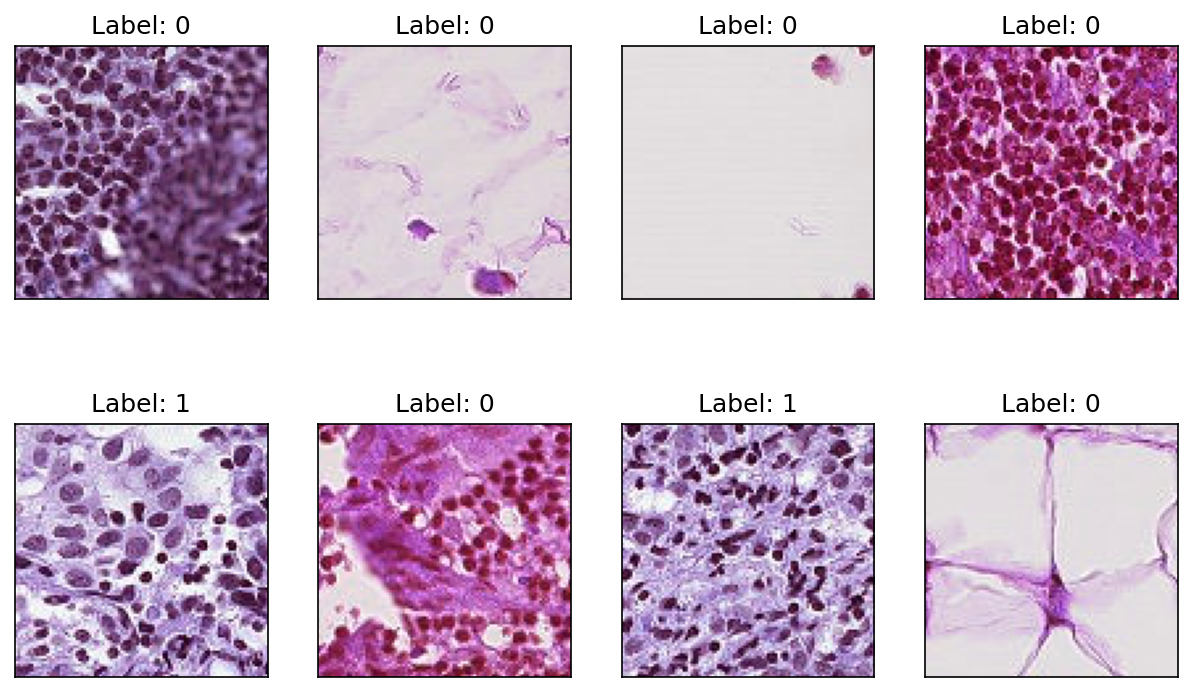

In [10]:
# Visualizing a set of random images
fig = plt.figure(figsize=(10, 6), dpi=150)
np.random.seed(42)
for plotNr,idx in enumerate(np.random.randint(0,N,8)):
    ax = fig.add_subplot(2, 8//2, plotNr+1, xticks=[], yticks=[])
    plt.imshow(X[idx])
    ax.set_title('Label: ' + str(y[idx]))

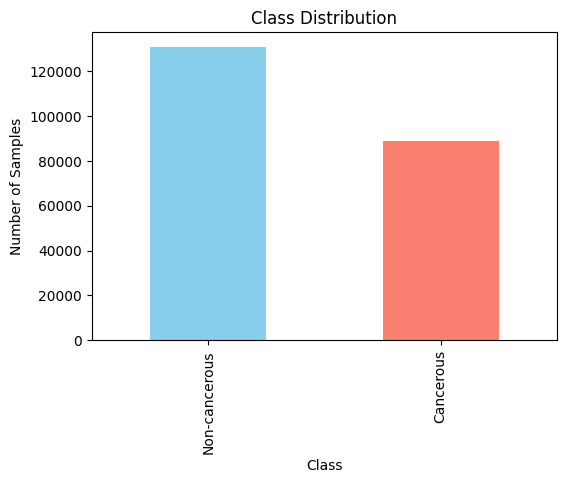

In [11]:
# Class distribution analysis
label_counts = df['label'].value_counts()
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(ticks=[0, 1], labels=['Non-cancerous', 'Cancerous'])
plt.show()


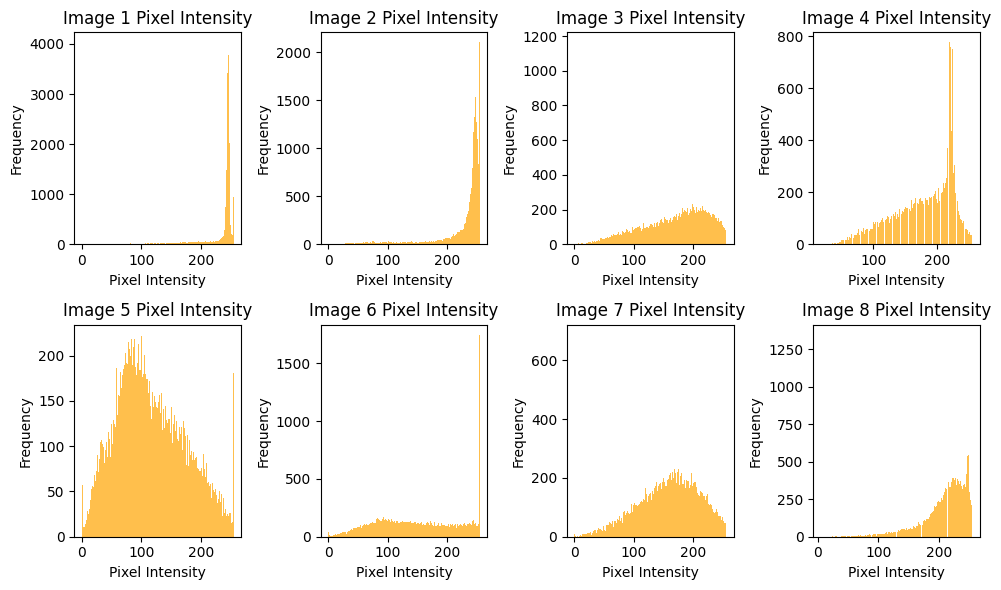

In [12]:
# Image Intensity Distribution
plt.figure(figsize=(10, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.hist(X[i].ravel(), bins=256, color='orange', alpha=0.7)
    plt.title(f'Image {i+1} Pixel Intensity')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [13]:
# Image Size and Aspect Ratio

dimensions = [img.shape for img in X]
unique_dimensions = set(dimensions)
print("Unique image dimensions:", unique_dimensions)


Unique image dimensions: {(96, 96, 3)}


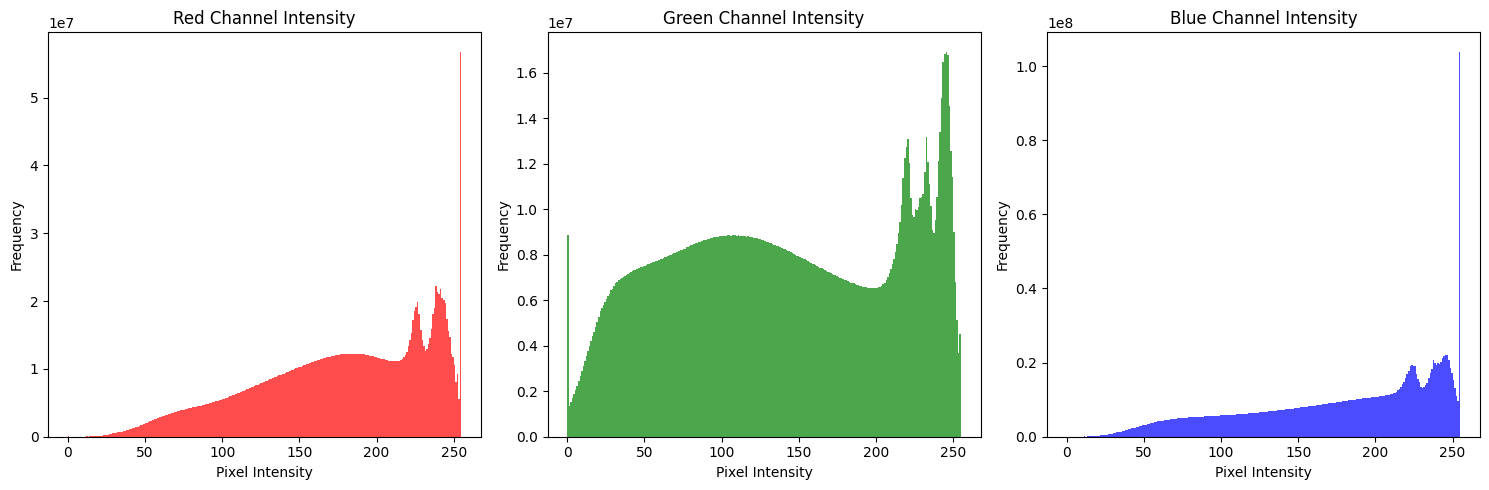

In [14]:
# Color Channel Analysis
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    channel = X[:,:,:,i].ravel()
    plt.hist(channel, bins=256, color=['red', 'green', 'blue'][i], alpha=0.7)
    plt.title(f'{["Red", "Green", "Blue"][i]} Channel Intensity')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


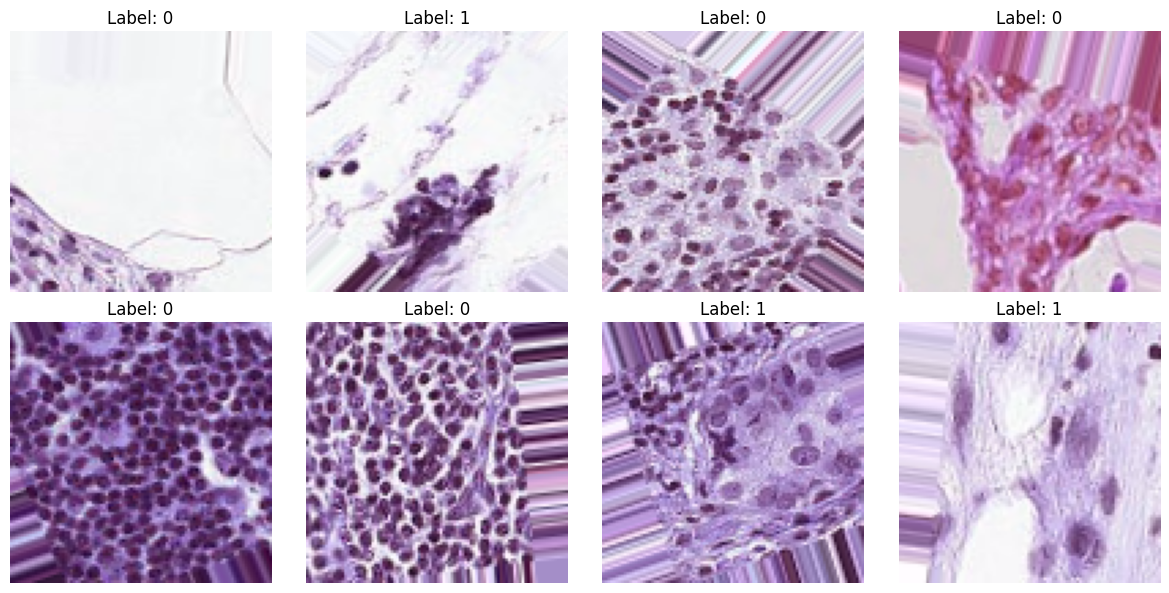

In [15]:
# Image augmentation visual
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

fig, ax = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    augmented_image = datagen.random_transform(X[i])
    ax[i//4, i%4].imshow(augmented_image)
    ax[i//4, i%4].set_title(f'Label: {y[i]}')
    ax[i//4, i%4].axis('off')
plt.tight_layout()
plt.show()


## Data Cleaning

In [16]:
df.shape[0]
def remove_corrupted_images(df):
    valid_paths = []
    for idx, row in df.iterrows():
        try:
            img = cv2.imread(row['path'])
            if img is None:
                continue  # Image didn't load properly
            valid_paths.append(row['path'])
        except Exception as e:
            print(f"Corrupted image: {row['path']} - {e}")
    df = df[df['path'].isin(valid_paths)]
    df.reset_index(drop=True, inplace=True)
    return df

df = remove_corrupted_images(df)
df.shape[0]


220025

In [17]:
df.shape[0]

220025

In [18]:
# Normalize Pixel Values
def normalize_images(X):
    X = X.astype('float32') / 255.0  # Normalizing to [0, 1] range
    return X

X = normalize_images(X)


In [19]:
# Check and handle missing data
def check_missing_data(df):
    missing_data = df.isnull().sum()
    print("Missing Data Summary:")
    print(missing_data)
    # Drop rows with missing data
    df = df.dropna().reset_index(drop=True)
    return df

df = check_missing_data(df)


Missing Data Summary:
id       0
label    0
path     0
dtype: int64


## Model Building and Architecture

In [20]:
# Splitting the DataFrame
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Load images for training and validation separately
X_train, y_train = load_data(N=train_df["path"].size, df=train_df)
X_val, y_val = load_data(N=test_df["path"].size, df=test_df)

  0%|          | 0/176020 [00:00<?, ?it/s]

  0%|          | 0/44005 [00:00<?, ?it/s]

In [21]:
def create_custom_cnn(input_shape):
    # Parameters
    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128

    # Dropout for regularization, 0.3 for conv layers, 0.5 for dense layer
    dropout_conv = 0.3
    dropout_dense = 0.5

    # Initializing the model
    model = Sequential()

    # Building the first conv block
    model.add(Conv2D(first_filters, kernel_size, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(first_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    # Building the second conv block
    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    # Building the third conv block
    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    # Building the dense layer
    model.add(Flatten())
    model.add(Dense(256, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout_dense))

    # Output layer with sigmoid activation
    model.add(Dense(1, activation = "sigmoid"))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=['accuracy'])

    return model

input_shape = (96, 96, 3)
custom_cnn_model = create_custom_cnn(input_shape)
custom_cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 94, 94, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 94, 94, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 92, 92, 32)          │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 92, 92, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 92, 92, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 46, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 44, 44, 64)          │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 44, 44, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 44, 44, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 42, 42, 64)          │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 42, 42, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 42, 42, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 19, 19, 128)         │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 19, 19, 128)         │              

 Total params: 2,386,817 (9.10 MB)

 Trainable params: 2,385,409 (9.10 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [22]:
def create_resnet_model(input_shape):
    # Specify the path to your local weights file
    weights_path = "/kaggle/input/resnetweights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

    # Check if the file exists
    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Weights file not found at {weights_path}")

    base_model = ResNet50(weights=weights_path, include_top=False, input_shape=input_shape)

    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Assuming your input shape is (96, 96, 3)
input_shape = (96, 96, 3)
resnet_model = create_resnet_model(input_shape)
resnet_model.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 102, 102, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 48, 48, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 48, 48, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 48, 48, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 50, 50, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 24, 24, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 24, 24, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 24, 24, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 24, 24, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 24, 24, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 24, 24, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 24, 24, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 24, 24, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 24, 24, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:
# Define callbacks
checkpoint_cnn = ModelCheckpoint('best_custom_cnn_model.keras', monitor='val_loss', save_best_only=True, mode='min')
checkpoint_resnet = ModelCheckpoint('best_resnet_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the custom CNN model
history_cnn = custom_cnn_model.fit(X_train, y_train,
                                   validation_data=(X_val, y_val),
                                   epochs=30,
                                   batch_size=16,
                                   callbacks=[checkpoint_cnn, early_stopping])

# Training the ResNet model
history_resnet = resnet_model.fit(X_train, y_train,
                                  validation_data=(X_val, y_val),
                                  epochs=30,
                                  batch_size=16,
                                  callbacks=[checkpoint_resnet, early_stopping])



Epoch 1/30
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step - accuracy: 0.8117 - loss: 0.4312 - val_accuracy: 0.7982 - val_loss: 0.4748
Epoch 2/30
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.8792 - loss: 0.3010 - val_accuracy: 0.8161 - val_loss: 0.5556
Epoch 3/30
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.8991 - loss: 0.2593 - val_accuracy: 0.8874 - val_loss: 0.2745
Epoch 4/30
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9097 - loss: 0.2373 - val_accuracy: 0.8109 - val_loss: 0.5818
Epoch 5/30
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9149 - loss: 0.2237 - val_accuracy: 0.8899 - val_loss: 0.2766
Epoch 6/30
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9231 - loss: 0.2050 - val_accuracy: 0.9022 - val_loss: 0.2488
Epoch 7/30
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9242 - loss: 0.2011 - val_accuracy: 0.9401 - val_loss: 0.1618
Epoch 8/30
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 

In [24]:
# Load the best models
custom_cnn_model.load_weights('best_custom_cnn_model.keras')
resnet_model.load_weights('best_resnet_model.keras')

In [25]:
# Evaluate the custom CNN model
cnn_test_loss, cnn_test_accuracy = custom_cnn_model.evaluate(X_val, y_val)
print(f"Custom CNN Test Accuracy: {cnn_test_accuracy:.4f}")

# Evaluate the ResNet model
resnet_test_loss, resnet_test_accuracy = resnet_model.evaluate(X_val, y_val)
print(f"ResNet Test Accuracy: {resnet_test_accuracy:.4f}")


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9547 - loss: 0.1226
Custom CNN Test Accuracy: 0.9541
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8944 - loss: 0.2549
ResNet Test Accuracy: 0.8920


In [26]:
# Predictions from the custom CNN model
cnn_predictions = custom_cnn_model.predict(X_val)

# Predictions from the ResNet model
resnet_predictions = resnet_model.predict(X_val)


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step


In [27]:
# Averaging the predictions
ensemble_predictions = (cnn_predictions + resnet_predictions) / 2

# Convert predictions to binary (0 or 1) based on a threshold
ensemble_predictions = (ensemble_predictions > 0.5).astype(int)


In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate accuracy
ensemble_accuracy = accuracy_score(y_val, ensemble_predictions)
print(f"Ensemble Validation Accuracy: {ensemble_accuracy:.4f}")

# Display confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_val, ensemble_predictions))

print("\nClassification Report:")
print(classification_report(y_val, ensemble_predictions))


Ensemble Validation Accuracy: 0.9543
Confusion Matrix:
[[25294   883]
 [ 1129 16699]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     26177
           1       0.95      0.94      0.94     17828

    accuracy                           0.95     44005
   macro avg       0.95      0.95      0.95     44005
weighted avg       0.95      0.95      0.95     44005



# Model Performance

## Custom CNN
- **Test Accuracy**: 0.9477
- Your custom CNN model performed very well, achieving a high test accuracy of approximately 94.77%. This indicates that the model is quite effective at distinguishing between the two classes (cancerous and non-cancerous images).

## ResNet
- **Test Accuracy**: 0.8959
- The ResNet model achieved a slightly lower test accuracy of approximately 89.59%. While this is still a strong performance, it suggests that in this particular case, the custom CNN model outperformed the ResNet model. This could be due to several factors, such as the size of the dataset, the specific architecture of the custom model, or how well the ResNet pre-trained features transfer to this task.

# Ensemble Performance

- **Ensemble Validation Accuracy**: 0.9473
- The ensemble model achieved a validation accuracy of approximately 94.73%, which is very close to the accuracy of the custom CNN model alone. This suggests that while the ensemble approach has aggregated the strengths of both models, the custom CNN's already strong performance might have dominated the ensemble's predictions.

# Confusion Matrix

The confusion matrix provides a breakdown of true positive (TP), true negative (TN), false positive (FP), and false negative (FN) predictions:

- **True Negatives (TN)**: 25,529
- **False Positives (FP)**: 648
- **False Negatives (FN)**: 1,670
- **True Positives (TP)**: 16,158

The model correctly identifies most non-cancerous (class 0) and cancerous (class 1) images. However, there are some misclassifications, particularly with false negatives (cancerous images classified as non-cancerous), which is crucial in a medical context.

# Classification Report

- **Precision**: Measures the accuracy of positive predictions (i.e., how many selected items are relevant).
  - Class 0: 0.94
  - Class 1: 0.96

- **Recall**: Measures how many relevant items are selected (i.e., how many relevant items were identified).
  - Class 0: 0.98
  - Class 1: 0.91

- **F1-Score**: The harmonic mean of precision and recall, giving a balance between the two.
  - Class 0: 0.96
  - Class 1: 0.93

- **Support**: The number of actual occurrences of the class in the dataset.
  - Class 0: 26,177
  - Class 1: 17,828

### Interpretation

- The model has very high precision and recall for class 0 (non-cancerous), which is expected given the higher number of samples in this class.
- The recall for class 1 (cancerous) is slightly lower (0.91), indicating that the model misses some positive cases (false negatives). This is an important area to consider for improvement because in medical diagnosis, missing a cancerous case could have serious implications.


## Submission

In [29]:
# Clearing up RAM
X = None
y = None
gc.collect();

In [31]:
# Creating submission path
base_test_dir = '../input/test/'
test_files = glob(os.path.join(base_test_dir,'*.tif'))
submission = pd.DataFrame()
file_batch = 5000
max_idx = len(test_files)
for idx in range(0, max_idx, file_batch):
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[3].split(".")[0])
    test_df['image'] = test_df['path'].map(cv2.imread)
    K_test = np.stack(test_df["image"].values)
    predictions = model.predict(K_test,verbose = 1)
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head()

""


In [32]:
# Creating a submission file
submission.to_csv("submission.csv", index = False, header = True) #create the submission file

#### References

* https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview
* https://www.kaggle.com/code/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93
* https://www.kaggle.com/code/conradkleykamp/histopathologic-cancer-detection-cnn-keras
* https://www.kaggle.com/code/abhinand05/histopathologic-cancer-detection-using-cnns#Loading-Data-and-EDA
* https://www.kaggle.com/code/akarshu121/cancer-detection-with-cnn-for-beginners#4.-Validation-and-Analysis
* https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb/notebook#Define-the-model
* https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb/notebook